# T-matrix computation for 3D acoustic scattering 

In [4]:
import bempp.api
import numpy as np
import scipy
from numba import objmode
import numba
import math
%matplotlib inline
import matplotlib.pyplot as plt
from bempp.api.operators.far_field import helmholtz as helmholtz_farfield
bempp.core.opencl_kernels.set_default_device(0,0)

In [7]:
def normalized_spherical_harmonics(p, q, x):
    """Spherical Harmonic function of degree q"""
    azimuth = np.arctan2(x[1],x[0])
    polar = np.arccos(x[2]/np.linalg.norm(x))
    if p >= 0:
        return ((-1)**p) * scipy.special.sph_harm(p,q,azimuth,polar)
    else:
        return scipy.special.sph_harm(-p,q,azimuth,polar)*np.exp(1j*2*p*azimuth)

def spherical_bessel_function(q,x):
    """Spherical Bessel function of degree q"""
    r = np.linalg.norm(x)
    return np.sqrt(np.pi/(2*wavenumber*r))*scipy.special.jv(q+0.5, wavenumber*r)

def regular_spherical_wavefunctions(p,q,x):
    """Regular Spherical Wavefunction"""
    return spherical_bessel_function(q,x)*normalized_spherical_harmonics(p,q,x)

In [3]:
def coeff_sph_expansion(p,q):
    """Analytical formula of the coefficients of the spherical expansions of plane waves"""
    coeff = 4*np.pi*(1j)**q*normalized_spherical_harmonics(-p,q,d)/(-1)**(abs(p))
    return coeff

In [9]:
def sca_far_field(x):
    fun = 0
    i = 0
    for q in range(deg+1):
        for p in range(-q,q+1):
            fun += coeff_sca[i]*(1/wavenumber)*(-1j)**(q+1) * normalized_spherical_harmonics(p, q, x)
            i +=1
    return fun

def sca_far_field1(x):
    fun = 0
    i = 0
    for q in range(deg+1):
        for p in range(-q,q+1):
            fun += coeff_sca1[i]*(1/wavenumber)*(-1j)**(q+1) * normalized_spherical_harmonics(p, q, x)
            i +=1
    return fun

In [6]:
d = [1,0,0] # wave's travel direction
wavenumber = 4 # wavenumber
eta = wavenumber

In [12]:
error_list1 = []
error_list = []
for deg in [5,7,9,11,13,15]:
    for h in [0.03,0.05,0.07,0.09]:
        cube1 = bempp.api.shapes.cube(length = 0.5, origin=(-0.75,-0.25,-0.25), h = h)
        cube2 = bempp.api.shapes.cube(length = 0.5, origin=(0.25,-0.25,-0.25), h = h)
        combined_scatters = bempp.api.grid.grid.union([cube1,cube2])

        unit_sphere = bempp.api.shapes.sphere(r = 1, origin=(0,0,0), h = h)
        vert_unit_sphere = unit_sphere.vertices
        space_unit_sphere = bempp.api.function_space(unit_sphere, 'P', 1)

        space_cube1 = bempp.api.function_space(cube1, "P", 1)
        space_combined = bempp.api.function_space(combined_scatters,'P',1)

        identity1 = bempp.api.operators.boundary.sparse.identity(space_cube1, space_cube1, space_cube1)
        slp1 = bempp.api.operators.boundary.helmholtz.single_layer(space_cube1, space_cube1, space_cube1, wavenumber)
        dlp1 = bempp.api.operators.boundary.helmholtz.double_layer(space_cube1, space_cube1, space_cube1, wavenumber)
        slp_far1 = helmholtz_farfield.single_layer(space_cube1, vert_unit_sphere, wavenumber)
        dlp_far1 = helmholtz_farfield.double_layer(space_cube1, vert_unit_sphere, wavenumber)

        lhs1 = 0.5 * identity1 + dlp1 - 1j* eta *slp1

        identity = bempp.api.operators.boundary.sparse.identity(space_combined, space_combined, space_combined)
        slp = bempp.api.operators.boundary.helmholtz.single_layer(space_combined, space_combined, space_combined, wavenumber)
        dlp = bempp.api.operators.boundary.helmholtz.double_layer(space_combined, space_combined, space_combined, wavenumber)
        slp_far = helmholtz_farfield.single_layer(space_combined, vert_unit_sphere, wavenumber)
        dlp_far = helmholtz_farfield.double_layer(space_combined, vert_unit_sphere, wavenumber)

        lhs = 0.5 * identity + dlp - 1j* eta *slp

        slp_far_field_coeff = []
        slp_far_field_coeff1 = []
        sph_harm_coeff = []

        for q in range(deg+1):
            for p in range(-q,q+1):
                @bempp.api.complex_callable
                def dirichlet_fun(x,n,domain_index,result):
                        with objmode():
                            result[0] = - regular_spherical_wavefunctions(p,q,x)

                rhs_fun = bempp.api.GridFunction(space_combined, fun = dirichlet_fun)
                field, info = bempp.api.linalg.gmres(lhs, rhs_fun, tol=1E-5)
                slp_far_field_coeff.append(dlp_far.evaluate(field) - 1j * eta * slp_far.evaluate(field))
                
                rhs_fun1 = bempp.api.GridFunction(space_cube1, fun = dirichlet_fun)
                field1, info1 = bempp.api.linalg.gmres(lhs1, rhs_fun1, tol=1E-5)
                slp_far_field_coeff1.append(dlp_far1.evaluate(field1) - 1j * eta * slp_far1.evaluate(field1))

                @bempp.api.complex_callable
                def sph_harm(x,n,domain_index,result):
                    with objmode():
                        result[0] = normalized_spherical_harmonics(p,q,x)
                sph_harm_grid = bempp.api.GridFunction(space_unit_sphere,fun = sph_harm)
                sph_harm_coeff.append(np.conj(sph_harm_grid.coefficients)/((-1j)**(q+1)))

        mass_mat = bempp.api.operators.boundary.sparse.identity(space_unit_sphere,space_unit_sphere,space_unit_sphere).weak_form().A

        T_matrix = np.zeros(((deg+1)**2,(deg+1)**2),dtype = complex)
        for i in range((deg+1)**2):
            for j in range((deg+1)**2):
                T_matrix[i,j] = (slp_far_field_coeff[j] @ mass_mat @ sph_harm_coeff[i])*wavenumber
                
        T_matrix1 = np.zeros(((deg+1)**2,(deg+1)**2),dtype = complex)
        for i in range((deg+1)**2):
            for j in range((deg+1)**2):
                T_matrix1[i,j] = (slp_far_field_coeff1[j] @ mass_mat @ sph_harm_coeff[i])*wavenumber


        coeff_inc = []
        for q in range(deg+1):
            for p in range(-q, q+1):
                coeff_inc.append(coeff_sph_expansion(p,q))

        coeff_sca = T_matrix @ coeff_inc
        coeff_sca1 = T_matrix1 @ coeff_inc

        far_list_test = []
        for i in range(vert_unit_sphere.shape[1]):
            far_list_test.append(sca_far_field(vert_unit_sphere[:,i]))
        far_list_test1 = []
        for i in range(vert_unit_sphere.shape[1]):
            far_list_test1.append(sca_far_field1(vert_unit_sphere[:,i]))
            
        @bempp.api.complex_callable
        def exact_data(x, n, domain_index, result):
            result[0] = - np.exp(1j * k * x[0])

        grid_fun = bempp.api.GridFunction(space_combined, fun=exact_data)
        fun_exact, info_exact = bempp.api.linalg.gmres(lhs, grid_fun, tol=1E-5)
        res_exact = dlp_far.evaluate(fun_exact) - 1j * eta * slp_far.evaluate(fun_exact)
        err = np.sqrt((far_list_test - res_exact[0,:]) @ mass_mat @ np.conj(far_list_test - res_exact[0,:]))/np.sqrt(res_exact[0,:]@ mass_mat @ np.conj(res_exact[0,:]))
        error_list.append(err)
        
        grid_fun1 = bempp.api.GridFunction(space_cube1, fun=exact_data)
        fun_exact1, info_exact1 = bempp.api.linalg.gmres(lhs1, grid_fun1, tol=1E-5)
        res_exact1 = dlp_far1.evaluate(fun_exact1) - 1j * eta * slp_far1.evaluate(fun_exact1)
        err1 = np.sqrt((far_list_test1 - res_exact1[0,:]) @ mass_mat @ np.conj(far_list_test1 - res_exact1[0,:]))/np.sqrt(res_exact1[0,:]@ mass_mat @ np.conj(res_exact1[0,:]))
        error_list1.append(err1)
        print(h,deg,err,err1)


0.03 5 (0.00716470526390602+4.8038493669527554e-20j) (0.00669857059374593+3.6683685839762537e-22j)
0.05 5 (0.007762360891227459-6.869636662203057e-20j) (0.0073004714171894265+4.429175613935199e-20j)
0.07 5 (0.008693512230816965+1.2225245794355237e-19j) (0.008256025180790811+4.924716646829164e-20j)
0.09 5 (0.00992684400753474+5.679549928182847e-19j) (0.009560435451250364+0j)
0.03 7 (0.0011187164343894052+2.8412080541348667e-20j) (0.0013225968234982168+7.7737222875377425e-22j)
0.05 7 (0.0017731447130539982-2.671251770724534e-20j) (0.001758482973016746-3.225264310740544e-22j)
0.07 7 (0.002471559740914847+1.6353421050234405e-20j) (0.0029413705432486752+7.21584807456977e-21j)
0.09 7 (0.003877841770631872+2.0651838019775313e-19j) (0.004193600462587899+0j)
0.03 9 (0.0011015170662391533+2.0095234646465028e-20j) (0.0013111351863118973-3.789553922032678e-21j)
0.05 9 (0.0017625984740883625-1.6074898010893297e-20j) (0.0017500966121224062+7.322338724555666e-22j)
0.07 9 (0.0024646577551786977+2.9791

In [1]:
error_list = [0.00716470526390602, 0.007762360891227459, 0.008693512230816965, 0.00992684400753474,
             0.0011187164343894052, 0.0017731447130539982, 0.002471559740914847, 0.003877841770631872,
             0.0011015170662391533, 0.0017625984740883625, 0.0024646577551786977, 0.0038740638639543387,
             0.0011014939956052027, 0.0017626375979695567, 0.002465097357720449, 0.0038747533337679073,
             0.0011015103149779146, 0.0017627121219779614, 0.0024656861263867304, 0.003876026253909581,
             0.0011015205879540651, 0.001762807031787111, 0.002466139952692513, 0.003876994116476822]

In [2]:
list_1 = [error_list[0],error_list[4],error_list[8],error_list[12],error_list[16],error_list[20]]
list_2 = [error_list[1],error_list[5],error_list[9],error_list[13],error_list[17],error_list[21]]
list_3 = [error_list[2],error_list[6],error_list[10],error_list[14],error_list[18],error_list[22]]
list_4 = [error_list[3],error_list[7],error_list[11],error_list[15],error_list[19],error_list[23]]

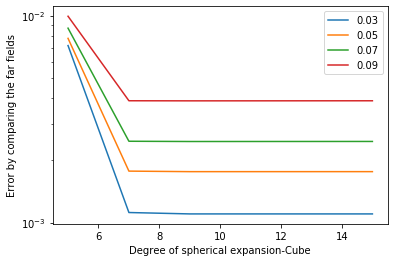

In [7]:
x_axis = [5,7,9,11,13,15]
fig = plt.figure()
ax = fig.add_subplot(111)
#ax.set_ylim(0.0005,0.1)
plt.semilogy(x_axis,list_1,label='0.03')
plt.semilogy(x_axis,list_2,label='0.05')
plt.semilogy(x_axis,list_3,label='0.07')
plt.semilogy(x_axis,list_4,label='0.09')
plt.xlabel('Degree of spherical expansion-Cube')
plt.ylabel('Error by comparing the far fields' )
plt.legend()
#plt.savefig('Converge by refining the grid3-Cube.pdf')

In [8]:
error_list1 = [0.00669857059374593, 0.0073004714171894265, 0.008256025180790811, 0.009560435451250364, 
               0.0013225968234982168, 0.001758482973016746, 0.0029413705432486752, 0.004193600462587899, 
               0.0013111351863118973, 0.0017500966121224062, 0.0029368640954112713, 0.004191221637052266,
               0.00131111382300863, 0.0017501458911600837, 0.0029372065541537393, 0.004192132220638014, 
               0.001311127155137216, 0.0017502358083590812, 0.0029376970793254433, 0.004193438741406196,
               0.0013111371029958978, 0.0017503566158135863, 0.0029381356550398805, 0.0041944852111738505]

In [9]:
list_1_ = [error_list1[0],error_list1[4],error_list1[8],error_list1[12],error_list1[16],error_list1[20]]
list_2_ = [error_list1[1],error_list1[5],error_list1[9],error_list1[13],error_list1[17],error_list1[21]]
list_3_ = [error_list1[2],error_list1[6],error_list1[10],error_list1[14],error_list1[18],error_list1[22]]
list_4_ = [error_list1[3],error_list1[7],error_list1[11],error_list1[15],error_list1[19],error_list1[23]]

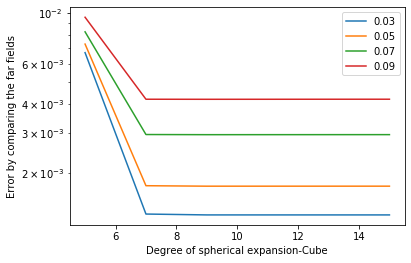

In [10]:
x_axis = [5,7,9,11,13,15]
fig = plt.figure()
ax = fig.add_subplot(111)
#ax.set_ylim(0.0005,0.1)
plt.semilogy(x_axis,list_1_,label='0.03')
plt.semilogy(x_axis,list_2_,label='0.05')
plt.semilogy(x_axis,list_3_,label='0.07')
plt.semilogy(x_axis,list_4_,label='0.09')
plt.xlabel('Degree of spherical expansion-Cube')
plt.ylabel('Error by comparing the far fields' )
plt.legend()
#plt.savefig('Converge by refining the grid3-Cube.pdf')